In [1]:
%matplotlib inline
import sys
sys.path.append("/home/mette/github/implicitmodules")


# Unstructured Shape Matching

In this tutorial, we register two curves with IMODAL without deformation prior.
To achieve this, a local translation deformation module is used.



## Initialization

Import relevant Python modules.




In [2]:
import sys
sys.path.append("../")

import math
import copy

import torch
import matplotlib.pyplot as plt

import imodal

imodal.Utilities.set_compute_backend('torch')

First, we generate the **source** (circle) and the **target** (square) and plot them.




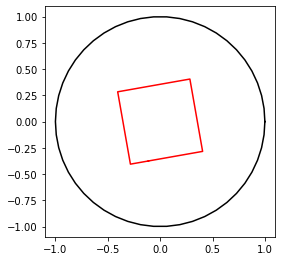

In [3]:
nb_points_source = 50
radius = 1.
source = radius*imodal.Utilities.generate_unit_circle(nb_points_source)

#nb_points_square_side = 12
#source = imodal.Utilities.generate_unit_square(nb_points_square_side)
#source = imodal.Utilities.linear_transform(source, imodal.Utilities.rot2d(-math.pi/14.))


nb_points_square_side = 4
target = 0.7*imodal.Utilities.generate_unit_square(nb_points_square_side)
target = imodal.Utilities.linear_transform(target, imodal.Utilities.rot2d(math.pi/18.))


plt.figure(figsize=[4., 4.])

imodal.Utilities.plot_closed_shape(source, color='black')
imodal.Utilities.plot_closed_shape(target, color='red')

plt.axis('equal')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

From these objects, **DeformablePoints** are created to be used for the registration.
This is a sub class of **Deformables** which represents geometrical objects that can be deformed by the framework.




In [4]:
source_deformable = imodal.Models.DeformablePoints(source)
target_deformable = imodal.Models.DeformablePoints(target)

We define the local translation module **translation**: we need to specify the gaussian
kernel scale (**sigma_translation**). We initialize its geometrical descriptor (**gd**) with the source points.




In [5]:
sigma_translation = 1.
# sigma_translation1 = 0.1
# sigma_translation2 = 0.2
translation = imodal.DeformationModules.ImplicitModule0(2, source.shape[0], sigma_translation, nu=1e-4, gd=source)
# translation1 = imodal.DeformationModules.ImplicitModule0(2, source.shape[0], sigma_translation1, gd=source, nu=0.1)
# translation2 = imodal.DeformationModules.ImplicitModule0(2, source.shape[0], sigma_translation2, gd=source, nu=0.1)

The distance between the deformed source and the target is measured using the
varifold framework, which does not require point correspondance. The spatial
kernel is a scalar gaussian kernel for which we specify the scale **sigma_varifold**.




In [6]:
sigma_varifold = [0.5]
attachment = imodal.Attachment.VarifoldAttachment(2, sigma_varifold, backend='torch')

## Registration

We create the registration model.
The **lam** parameter is the weight of the attachment term of the total energy to minimize.




In [7]:
model = imodal.Models.RegistrationModel(source_deformable, [translation], attachment, lam=100.)

We launch the energy minimization using the **Fitter** class.
We specify the ODE solver algorithm **shoot_solver** and the number of iteration steps **shoot_it** used to integrate the shooting equation.
The optimizer can be manually selected. Here, we select Pytorch's LBFGS algorithm with strong Wolfe termination conditions.
**max_iter** defines the maximum number of iteration for the optimization.




In [8]:
shoot_solver = 'euler'
shoot_it = 10

fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')
max_iter = 10

fitter.fit(target_deformable, max_iter, options={'line_search_fn': 'strong_wolfe', 'shoot_solver': shoot_solver, 'shoot_it': shoot_it})

Starting optimization with method torch LBFGS, using solver euler with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 535.1494140625}
1e-10
Evaluated model with costs=535.1494140625
Evaluated model with costs=306.9248187690973
Evaluated model with costs=27.595403790473938
Evaluated model with costs=19.349234700202942
Evaluated model with costs=44.17715498805046
Evaluated model with costs=7.8644750118255615
Evaluated model with costs=8.302552819252014
Evaluated model with costs=7.862510919570923
Evaluated model with costs=7.861268401145935
Evaluated model with costs=7.860142409801483
Evaluated model with costs=7.859388828277588
Evaluated model with costs=7.855266690254211
Evaluated model with costs=7.852717041969299
Evaluated model with costs=7.839367389678955
Evaluated model with costs=7.80333548784256
Evaluated model with costs=7.687591195106506
Evaluated model with costs=7.312543988227844
Evaluated model with costs=7.089033246040344
Evaluated model with costs=5.9149334430

## Displaying results

We compute the optimized deformation.




In [9]:
intermediates = {}
with torch.autograd.no_grad():
    deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]

We display the result.




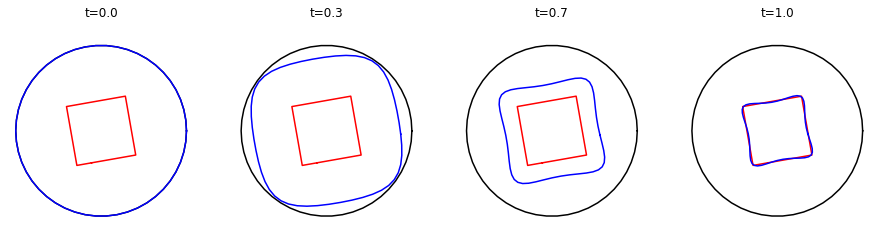

In [10]:
display_index = [0, 3, 7, 10]
plt.figure(figsize=[3.*len(display_index), 3.])
for count, i in enumerate(display_index):
    plt.subplot(1, len(display_index), 1+count).set_title("t={}".format(i/10.))

    deformed_i = intermediates['states'][i][0].gd

    imodal.Utilities.plot_closed_shape(source, color='black')
    imodal.Utilities.plot_closed_shape(target, color='red')

    imodal.Utilities.plot_closed_shape(deformed_i, color='blue')
    plt.axis('equal')
    plt.axis('off')

plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
plt.show()

In order to visualize the deformation, we will compute the grid deformation.
We first retrieve the modules and initialize their manifolds (with initial values of geometrical descriptor and momentum).




In [11]:
modules = imodal.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone())

We initialize a grid built from a bounding box and a grid resolution.
We create a bounding box **aabb** around the source, scaled with a 1.3 factor to enhance the visualization of the deformation.
Then, we define the grid resolution **grid_resolution** from the size of each grid gap **square_size**.
Finally, we create a silent deformation module **deformation_grid** whose geometrical descriptor is made of the grid points.




In [12]:
aabb = imodal.Utilities.AABB.build_from_points(source).scale(1.3)
square_size = 0.05
grid_resolution = [math.floor(aabb.width/square_size),
                   math.floor(aabb.height/square_size)]

deformation_grid = imodal.DeformationModules.DeformationGrid(aabb, grid_resolution)

We inject the newly created deformation module **deformation_grid** into the list of deformation modules **modules_grid**.
We create the hamiltonian structure **hamiltonian** allowing us to integrate the shooting equation.
We then recompute the deformation, now tracking the grid deformation.




In [13]:
modules_grid = [*modules, deformation_grid]
hamiltonian = imodal.HamiltonianDynamic.Hamiltonian(modules_grid)

intermediates_grid = {}
with torch.autograd.no_grad():
    imodal.HamiltonianDynamic.shoot(hamiltonian, shoot_solver, shoot_it, intermediates=intermediates_grid)

We display the result along with the deformation grid.




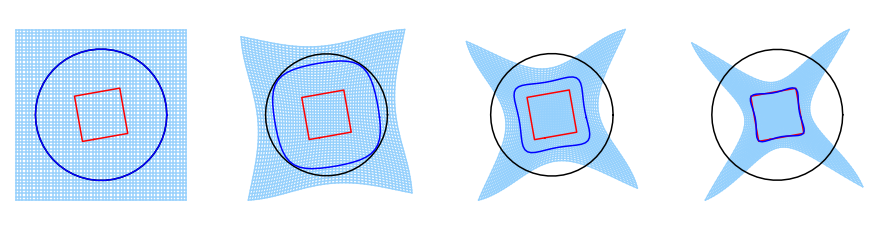

In [14]:
display_index = [0, 3, 7, 10]
plt.figure(figsize=[3.*len(display_index), 3.])
for count, i in enumerate(display_index):
    ax = plt.subplot(1, len(display_index), 1+count)
    # ax.set_title("t={}".format(i/10.))

    deformed_i = intermediates_grid['states'][i][0].gd

    deformation_grid.manifold.fill_gd(intermediates_grid['states'][i][-1].gd)
    grid_x, grid_y = deformation_grid.togrid()

    imodal.Utilities.plot_grid(ax, grid_x, grid_y, color='xkcd:light blue')
    imodal.Utilities.plot_closed_shape(source, color='black')
    imodal.Utilities.plot_closed_shape(target, color='red')

    imodal.Utilities.plot_closed_shape(deformed_i, color='blue')
    plt.axis('equal')
    plt.axis('off')

plt.subplots_adjust(left=0., right=1., top=1., bottom=0.)
plt.show()